![](https://images.pexels.com/photos/1148820/pexels-photo-1148820.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Extended Kalman Filter (EKF)

Kevin J. Walchko, Phd

19 Apr 2020

---

In estimation theory, the extended Kalman filter (EKF) is the nonlinear version of the Kalman filter which linearizes about an estimate of the current mean and covariance. In the case of well defined transition models, the EKF has been considered[1] the de facto standard in the theory of nonlinear state estimation, navigation systems and GPS.

## References

- Wikipedia: [Extended Kalman Filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter)

In the extended Kalman filter, the state transition and observation models don't need to be linear functions of the state but may instead be differentiable functions.

$$
\boldsymbol{x}_{k} = f(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k}) + \boldsymbol{w}_{k} \\
\boldsymbol{z}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}
$$

- $F_{k}$: state-transition model formed from the Jacobian of $f$
    - ${{\boldsymbol{F}_{k}}} = \left . \frac{\partial f}{\partial \boldsymbol{x} } \right \vert _{\hat{\boldsymbol{x}}_{k-1|k-1},\boldsymbol{u}_{k}} $
- $H_{k}$: observation model formed from the Jacobian of $h$
    - ${{\boldsymbol{H}_{k}}} = \left . \frac{\partial h}{\partial \boldsymbol{x} } \right \vert _{\hat{\boldsymbol{x}}_{k|k-1}}$
- $Q_{k}$: process noise covariance
    - $\mathbf{w}_k \sim \mathcal{N}\left(0, \mathbf{Q}_k\right)$, assumed gaussian and zero mean
- $R_{k}$: measurement noise covariance
    - $\mathbf{v}_k \sim \mathcal{N}\left(0, \mathbf{R}_k\right)$, assumed gaussian and zero mean

## Discrete EKF

Notation $\hat{\mathbf{x}}_{n\mid m}$ represents the estimate of $\mathbf{x}$ at time $n$ given observations up to and including at time $m \le n$.

#### Predict
- Predicted state estimate:    
    - $\hat{\boldsymbol{x}}_{k|k-1} = f(\hat{\boldsymbol{x}}_{k-1|k-1}, \boldsymbol{u}_{k})$
- Predicted covariance estimate: 
    - $\boldsymbol{P}_{k|k-1} =  {{\boldsymbol{F}_{k}}} \boldsymbol{P}_{k-1|k-1}{ {\boldsymbol{F}_{k}^\top}} + \boldsymbol{Q}_{k}$

#### Update
- Innovation or measurement residual
    - $\tilde{\boldsymbol{y}}_{k} = \boldsymbol{z}_{k} - h(\hat{\boldsymbol{x}}_{k|k-1})$
- Innovation (or residual) covariance
    - $\boldsymbol{S}_{k} = {{\boldsymbol{H}_{k}}}\boldsymbol{P}_{k|k-1}{{\boldsymbol{H}_{k}^\top}} + \boldsymbol{R}_{k}$
- *Near-optimal* Kalman gain
    - $\boldsymbol{K}_{k} = \boldsymbol{P}_{k|k-1}{{\boldsymbol{H}_{k}^\top}}\boldsymbol{S}_{k}^{-1} $
- Updated state estimate
    - $\hat{\boldsymbol{x}}_{k|k} = \hat{\boldsymbol{x}}_{k|k-1} + \boldsymbol{K}_{k}\tilde{\boldsymbol{y}}_{k}$
- Updated covariance estimate 
    - $\boldsymbol{P}_{k|k} = (\boldsymbol{I} - \boldsymbol{K}_{k} {{\boldsymbol{H}_{k}}}) \boldsymbol{P}_{k|k-1}$

In [1]:
import attr

import numpy as np
from numpy import cross
from numpy import dot
from numpy.linalg import inv

from pyrk import RK4

from math import sin, cos, pi

In [2]:
import attr

@attr.s(slots=True)
class Jacobian:
    f=attr.ib() # function
    
    # cache some variables to save processing time
    n=attr.ib(init=False, default=None)
    jac=attr.ib(init=False, default=None)
    
    def __call__(self, time, x, u, dx=1e-8):
        if self.n is None:
            self.n = len(x)
            self.jac = np.zeros((self.n, self.n))
        for j in range(self.n):
            Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
            d = np.zeros(self.n)
            d[j] = Dxj
            self.jac[:, j] = (self.f(time, x+d, u) - self.f(time, x-d, u))/(2*Dxj)
        return self.jac

In [30]:
class EKF(object):
    """
    Extended Kalman Filter (EKF)

    def func(time, x, u):
        some nonlinear eqns
        return dx

    ekf = EKF(size_x,size_z)
    ekf.init(x, func, R, Q)

    while True:
        ekf.predict(u)
        x_hat = ekf.update(z)
    """

    def reset(self, x, f, r, q):
        """
        x -  initial state
        f - dx = f(x, u)
        r - measurement noise
        q - process noise
        """
        state_size = len(x)
        self.F = np.eye(state_size)
        self.H = np.eye(state_size)
        self.P = np.eye(state_size)
        self.I = np.eye(state_size)
        
        self.x = x
        self.rk = RK4(f)
        self.jacob = Jacobian(f)
        self.R = r
        self.Q = q
        self.time = 0.0

    def something(self, time, u, dt):
        rk = self.rk
        t = self.time
        x = self.x

        y = rk.step(x, u, t, dt)
        self.F = self.jacob(time, y,u)

        self.time = t+dt
        self.x = y

        return y

    def predict(self, time, u, dt):
        self.x = self.something(time, u, dt)

        F = self.F
        Q = self.Q
        P = self.P

        self.P = dot(F, dot(P, F.T)) + Q

    def update(self, z):
        H = self.H
        R = self.R
        I = self.I
        P = self.P
        x = self.x

        K = dot(P, dot(H.T, inv(dot(H, dot(P, H.T)) + R)))
        x = x + K.dot(z-H*x)
        p = (I - K.dot(H)).dot(P)

        self.x = x
        self.P = p

        return x

In [33]:
def func(time, x, u):
    """
    Some cool non-linear function
    f = [x**2y; 5x+sin(y)]
    """
    f1 = x[0]**2*x[1]
    f2 = 5*x[0]+sin(x[1])
    
    return np.array([f1,f2])

ekf = EKF()
R = np.eye(2)*0.001
Q = R*0.1
x = np.array([1,2])
ekf.reset(x, func, R, Q)

In [34]:
u = np.array([0,0])
z = x
xx = []
for i in range(10):
    ekf.predict(0, u,0.1)
    x_hat = ekf.update(z)
    xx.append(x_hat)
    z = x_hat + np.array([gauss(.1,.001), gauss(.1,.001)])
    
xx

TypeError: only size-1 arrays can be converted to Python scalars

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

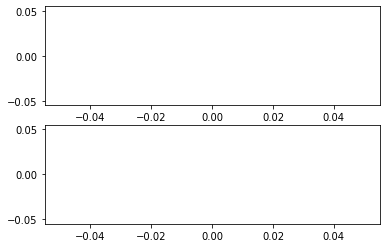

In [21]:
plt.subplot(2,1,1); plt.plot([x[0] for x in xx])
plt.subplot(2,1,2); plt.plot([x[1] for x in xx])

In [12]:
from random import gauss

In [18]:
xx

[array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan])]

In [23]:
np.ones(3)

array([1., 1., 1.])